# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 save_g2)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
from chxanalys.chx_compress import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)

%matplotlib notebook

In [3]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_SAXS.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_compress.py

In [4]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [5]:
#%reset

In [6]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /user/yuzhang/analysis/2016_3/commissioning/XPCS_SAXS_Single_Run_For_Au10nm.ipynb


## Make a directory for saving results

In [8]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "kyager"  #provide the username to force the results to save in that username folder
username = "commissioning"
date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/commissioning/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [186]:
uid = '05e27b' #count : 1 ['05e27b'] (scan num: 2968) (Measurement: CoralPor 1kHz 5k frames )

uid = '1a2b7a'     #count : 1 ['1a2b7a'] (scan num: 2970) (Measurement: CoralPor 1kHz 5k frames, MBS 0.2 V x 0.05H no feedback )

uid = 'eaed19'  #count : 1 ['eaed19'] (scan num: 3929) (Measurement: coralpor 750Hz 5k ) 

uid = '701275'  #count : 1 ['701275'] (scan num: 3930) (Measurement: coralpor 750Hz 5k mbs 200x400 )

uid = 'cab6bb' #count : 1 ['cab6bb'] (scan num: 3931) (Measurement: coralpor 750Hz 5k mbs 50x200 )

uid = '9877e656' #(Measurement: coralpor 750Hz 5k mbs 100x400 )

uid = 'ce269958'#  count : 1 ['ce2699'] (scan num: 4135) (Measurement: coralpor 750Hz 5k mbs: .1x.4 )

uid = '0c4e61' #count : 1 ['0c4e61'] (scan num: 4136) (Measurement: 50nm Au in PEG 750Hz 5k mbs: .1x.4 )

uid = '167f66'  #count : 1 ['167f66'] (scan num: 4148) (Measurement: 50nm Au in PEG test 500us expos mbs: .1x.4 )

uid = 'd72b2d'  #count : 1 ['d72b2d'] (scan num: 4150) (Measurement: 50nm Au in PEG test 250us exp. 750Hz 500fr mbs: .1x.4 )

uid = '436dc5'# count : 1 ['436dc5'] (scan num: 4145) (Measurement: 50nm Au in PEG 750Hz 200fr mbs: .1x.4 )'

uid = 'd72b2d' # (scan num: 4150) (Measurement: 50nm Au in PEG test 250us exp. 750Hz 500fr mbs: .1x.4 )

uid = '2c49e4' #(scan num: 4149) (Measurement: 50nm Au in PEG test 250us expos mbs: .1x.4 )

uid  =  'a5df4bbb-2c09'# #count : 1 ['a5df4b'] (scan num: 4151) (Measurement: 10nm Au in PEG 750Hz 500fr mbs: .1x.4 )

uid = '385cd9' #count : 1 ['385cd9'] (scan num: 4208) (Measurement: 10nm Au PEG after realignment )



In [187]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/commissioning/Results/385cd9/


# Don't Change these lines below here

In [188]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
full_uid = sud[1]
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  4208--385cd999-a00c-4563-8c13-77790f608fcc--/XF11ID/data/2016/11/01/4d4b1c91-3f9c-470d-9fb6_870


In [189]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/01/4d4b1c91-3f9c-470d-9fb6_870_master.h5


In [190]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    #md['sample']= 'SiO2 Colloidal'  #change the sample name if the md['sample'] is wrong
    print( 'The sample is %s' %md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

The sample is 10nm Au in 10wt PEG


In [191]:
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


## Overwrite Some Metadata if Wrong Input

In [192]:
print( 'The Metadata are: \n%s' %md )

The Metadata are: 
{'sample': '10nm Au in 10wt PEG', 'count_time': 0.00134, 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'Measurement': '10nm Au PEG after realignment', 'detector_distance': 4.8899999, 'beam_center_y': 789.0, 'y_pixel_size': 7.5000004e-05, 'frame_time': 0.00135, 'incident_wavelength': 1.2848103, 'beam_center_x': 1476.0, 'x_pixel_size': 7.5000004e-05}


In [193]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'],2167-md['beam_center_y']  ]   #for 4M
          # center of the speckle pattern
          #assuming it was correctly entered in the eiger css screen
#center = [  md['beam_center_x'],1065-md['beam_center_y']  ]   #for 4M
#center =    [1341,1381] 
#center =    [ 507, 758] 

center = [1475-4, 1381-0] 
center=[center[1], center[0]]
print ('Beam center=', center)






The sample is 10nm Au in 10wt PEG
Exposuretime=0.00134 sec, Acquisition_period=0.00135 sec
Beam center= [1381, 1471]


In [194]:
#Ldet =    4890  #in mm, in this experiments, we forget to change Ldet and kept the old 3990 mm

In [195]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir)

In [196]:
setup_pargs

{'Ldet': 4889.9998664855957,
 'center': [1381, 1471],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'path': '/XF11ID/analysis/2016_3/commissioning/Results/385cd9/',
 'timeperframe': 0.00135,
 'uid': '385cd9'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [197]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Octo28_4M_mask.npy'

<IPython.core.display.Javascript object>


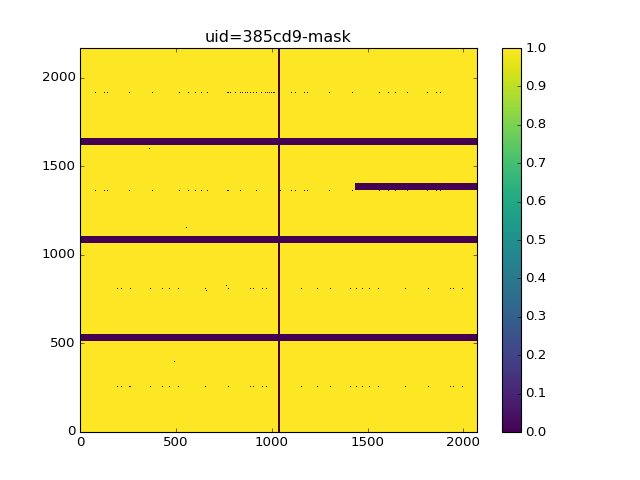

In [198]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid=%s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [199]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH
psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [200]:
imgsa = apply_mask( imgs, mask )

In [201]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


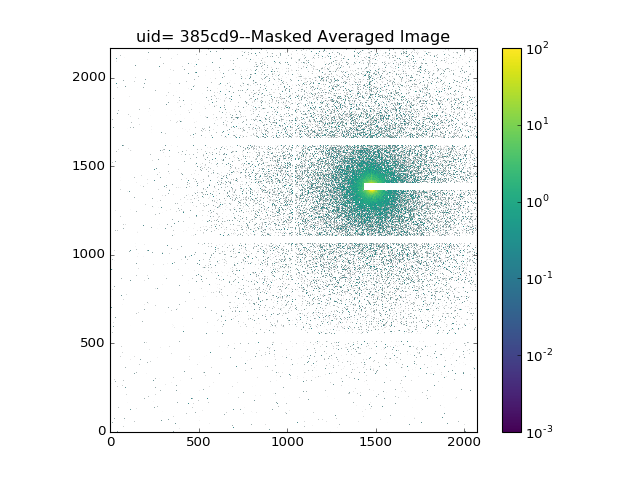

In [202]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

## Determine Compress Or Not

In [203]:
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress

print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.07094694461721608.
Will DO apply compress process.


## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [204]:
good_start = 0  #make the good_start at least 0

In [205]:
imgs

<Frames>
Length: 500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [95]:
#compress = True

Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_385cd999-a00c-4563-8c13-77790f608fcc.cmp.
Using a multiprocess to compress the data.
It will create 5 temporary files for parallel compression.


100%|██████████| 5/5 [00:25<00:00,  5.12s/it]


No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


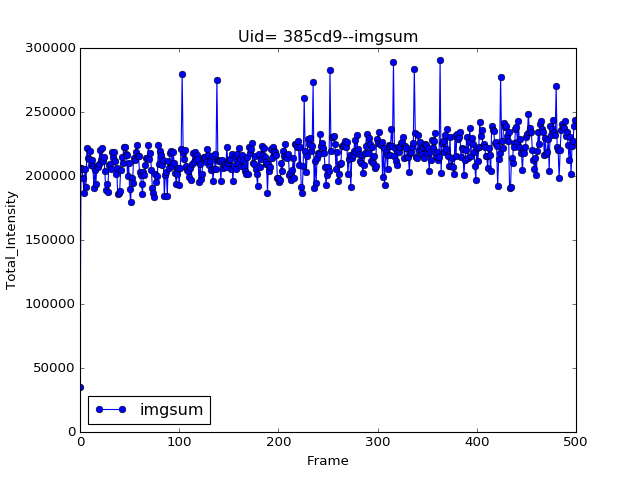

In [206]:
if True:
    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 1e14,nobytes=4,
                                            para_compress=True, num_sub= 100)    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, 10,100)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

In [94]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [207]:
bad_pixel_threshold= 2.5*10**5  # 2.4*10**15  #if re-define a bad pixel threshold
bad_pixel_low_threshold= 0#1.8*10**15  #if re-define a bad pixel threshold


In [208]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold, 
                bad_pixel_low_threshold= bad_pixel_low_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)


Averaging images:   4%|▍         | 21/500 [00:00<00:02, 207.22it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_385cd999-a00c-4563-8c13-77790f608fcc.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 1180.38it/s]

Bad frame list length is: 10
The good_start frame number is: 0 


## Define a good time series by defining a good start and good end

In [209]:
if False:
        good_start = 0  #0
        good_end =     len(imgs)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD,  bad_pixel_threshold= 1e14, plot_=False )                           


In [210]:
if not compress:   
    #sampling = 1   #sampling should be one
    sampling = 1000  #sampling should be one    
    
    good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = apply_mask( imgsa[good_start:], mask )
    avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold= 1e14,   plot_ = False, uid=uid)
    
    

In [211]:
#print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The number of bad frames is : 10 
The good_start frame number is: 0 


In [212]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
                            

<IPython.core.display.Javascript object>


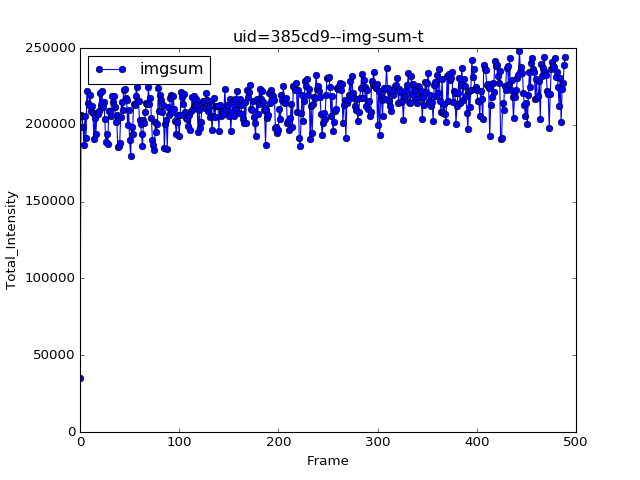

In [213]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

<IPython.core.display.Javascript object>


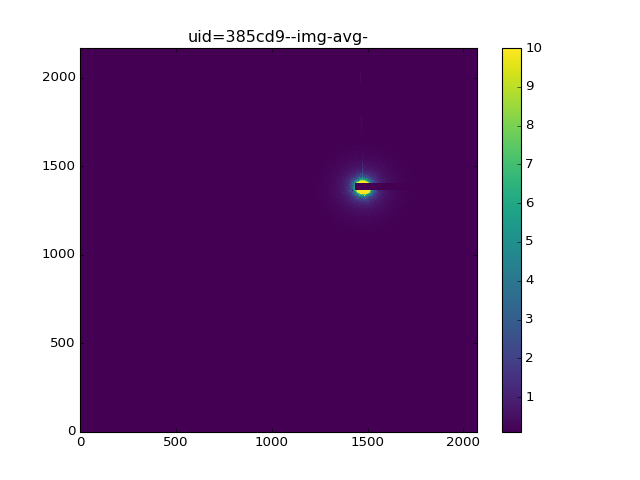

In [214]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=10, logs=False, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_img

## Get circular average 
* Do plot and save q~iq


In [215]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask

<IPython.core.display.Javascript object>


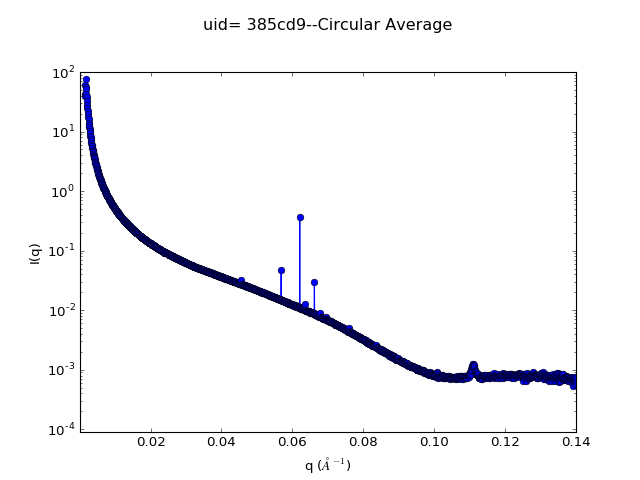

In [216]:
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e2], save=True)



# Fit Form Facotr

In [218]:
fit_form = False

In [219]:
if fit_form:
    form_res = fit_form_factor( q,iq,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])
    

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [220]:
uniform = True #False

### Define a non-uniform distributed rings by giving edges

In [221]:
if not uniform:
    #width = 4  # in pixel
    width = 0.001    
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.0065,0.0117,0.021,0.0336,0.044, 0.057] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [222]:
if uniform:
    inner_radius= 0.0018
    outer_radius = 0.04
    width = 0.0035
    num_rings = 10
    edges = None

In [223]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 



In [224]:
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]


psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

<IPython.core.display.Javascript object>


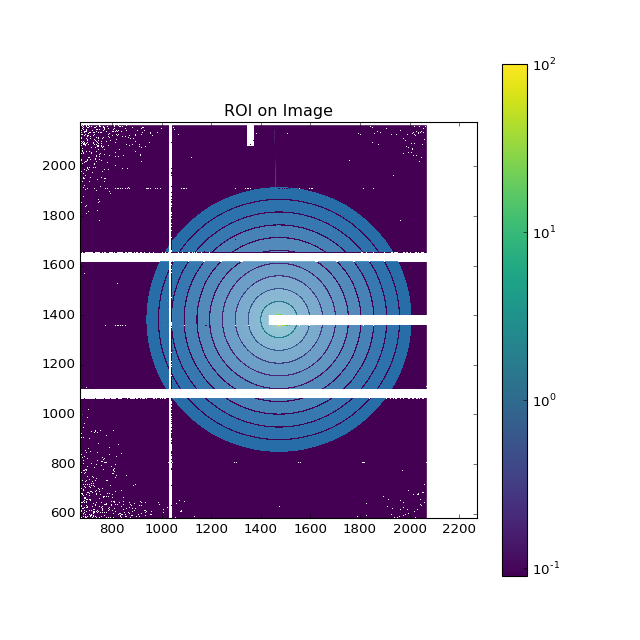

In [225]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=800, alpha=.9,
                 save=True, path=data_dir, uid=uid, vmin=.09, vmax=1e2)

<IPython.core.display.Javascript object>


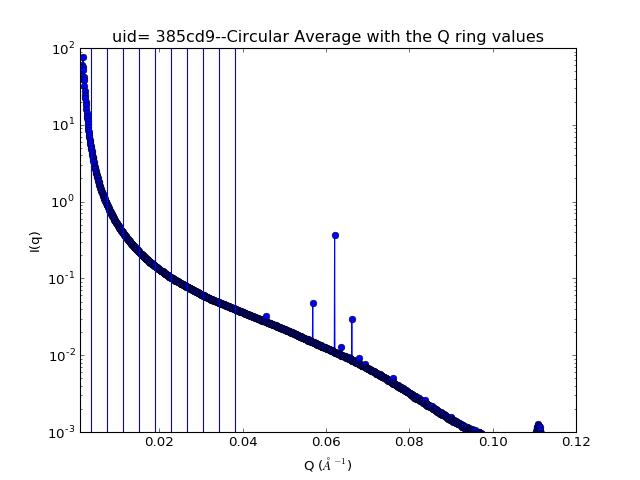

In [226]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.12],
                  ylim = [1e-3, 1e2],        save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


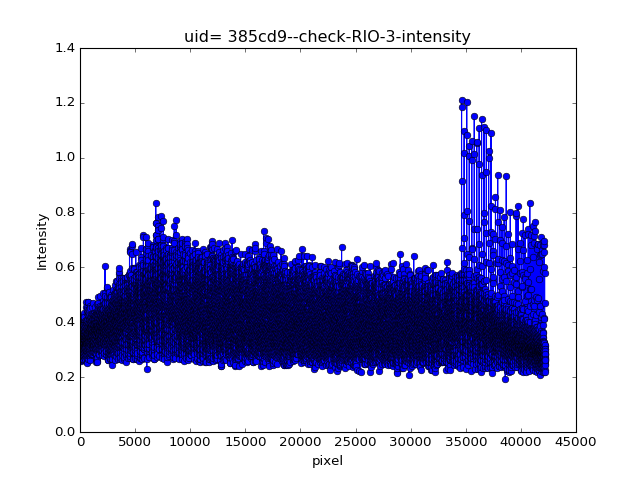

In [227]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 3, uid =uid, save=True, path=data_dir )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [228]:
#FD = Multifile(filename, good_start, len(imgs))

In [229]:
if compress:
    Nimg = FD.end - FD.beg
else:
    Nimg = len(imgsa  )

In [230]:
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
time_edge =  np.array( time_edge ) + good_start

Averaging images: 100%|██████████| 1/1 [00:00<00:00, 73.70it/s]


<IPython.core.display.Javascript object>


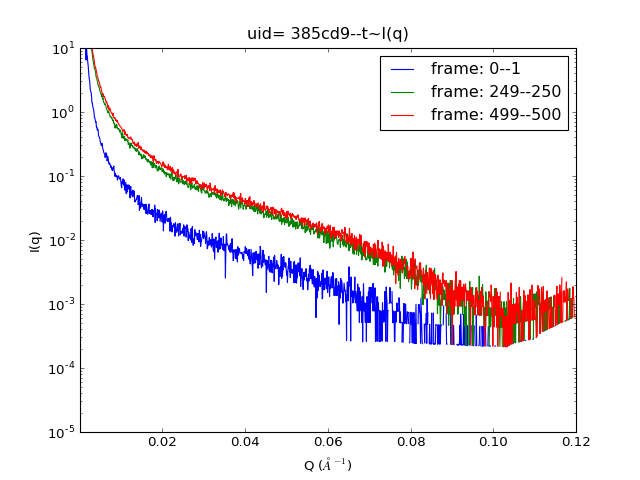

In [231]:
if compress:
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,   xlim=[0.0001,.12], ylim = [0.00001, 10], save=True, path=data_dir )
    
else:
    qpt, iqst, qt = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,    ylim = [0.0091, 1e3] ,xlim=[0.0001,.12], save=True)

## Do a waterfall analysis

In [232]:
if False:
    if compress:
        qindex = 3 
        wat = cal_waterfallc( FD, ring_mask, qindex= qindex, save =True, path=data_dir, uid=uid)

In [233]:
if False:
    if compress:
        plot_waterfallc( wat, qindex, aspect=None, 
                        vmax= 10, uid=uid, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 500/500 [00:01<00:00, 336.52it/s]


<IPython.core.display.Javascript object>


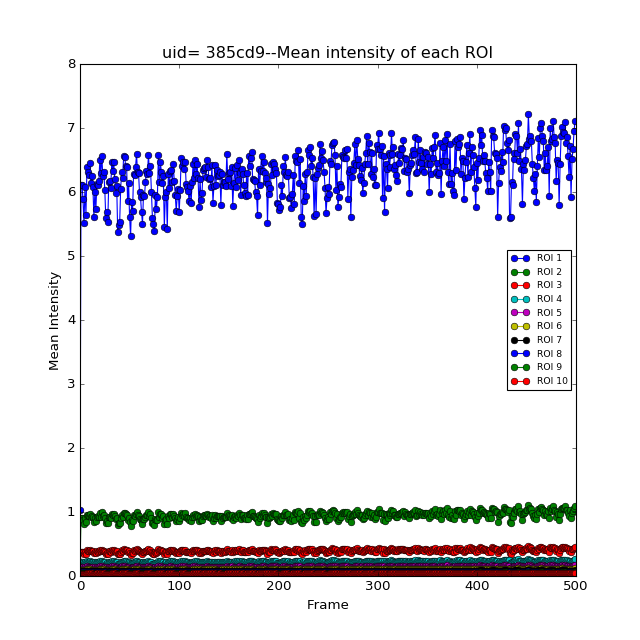

In [234]:
if True:
    if compress:
        times, mean_int_sets = get_each_ring_mean_intensityc(FD, ring_mask,
                        timeperframe = None, plot_ = True, uid = uid, save=True, path=data_dir  )
        ring_avg = np.average( mean_int_sets, axis=0)

    else:
        mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = sampling,
                timeperframe = md['frame_time']*sampling, 
                            plot_ = True, uid = uid, save=True, path=data_dir  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [235]:
if False:
    good_start = 0
    good_end =  2000
    good_series = apply_mask( imgs[good_start:good_end-1], mask )
    

In [236]:
lag_steps = None

In [237]:
#bad_frame_list

In [238]:
para_cal = True  #if True to use the parallel calculation


In [240]:
good_start = 10
good_end=500
FD = Multifile(filename, good_start, good_end )

In [241]:
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)

In [242]:
t0 = time.time()
if compress:
    if para_cal:
        g2, lag_steps  =cal_g2p( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
    else:
        g2, lag_steps  =cal_g2c( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )

    g2, lag_steps  =cal_g2( good_series,  ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
480 frames will be processed...


100%|██████████| 10/10 [00:01<00:00,  4.92it/s]


G2 calculation DONE!
Total time: 0.30 min


In [243]:
lag_steps

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  14,  16,
        20,  24,  28,  32,  40,  48,  56,  64,  80,  96, 112, 128, 160])

In [244]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [245]:
#taus

In [246]:
save_saxs_g2(   g2, res_pargs )

The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/385cd9/ with filename as uid=385cd9--g2.csv


<IPython.core.display.Javascript object>


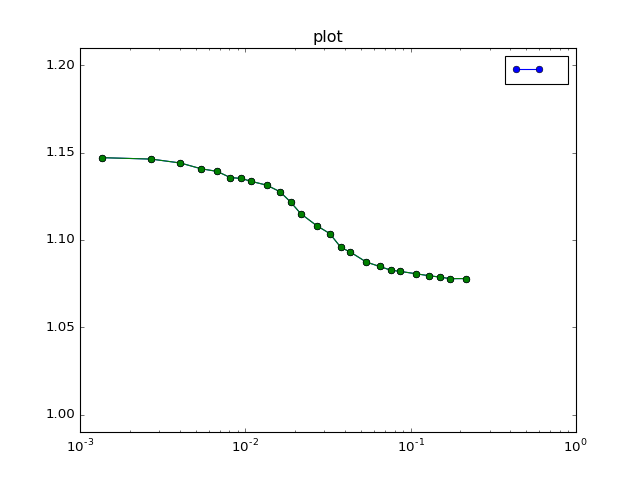

In [247]:
plot1D( x=taus, y=g2[:,0], logx=True, ylim=[0.99,1.21])

In [503]:
1/0.0368

27.17391304347826

In [504]:
1/60

0.016666666666666666

### Plot the one time correlation functions

<IPython.core.display.Javascript object>


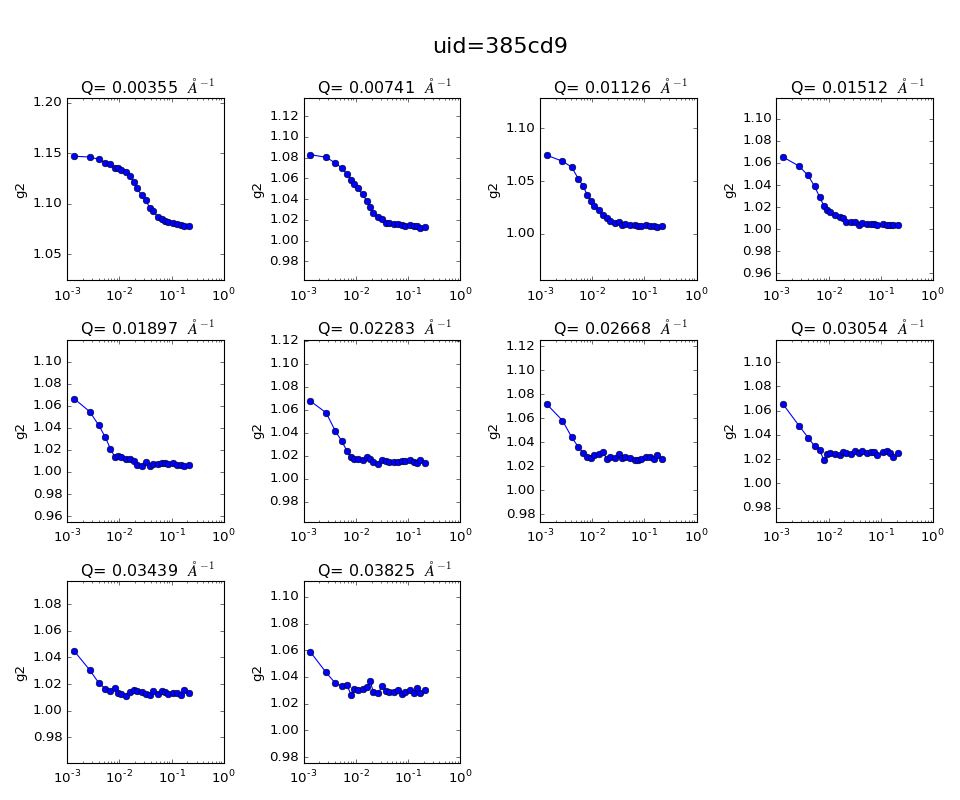

In [248]:
plot_saxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit g2

In [249]:
fit= True

<IPython.core.display.Javascript object>


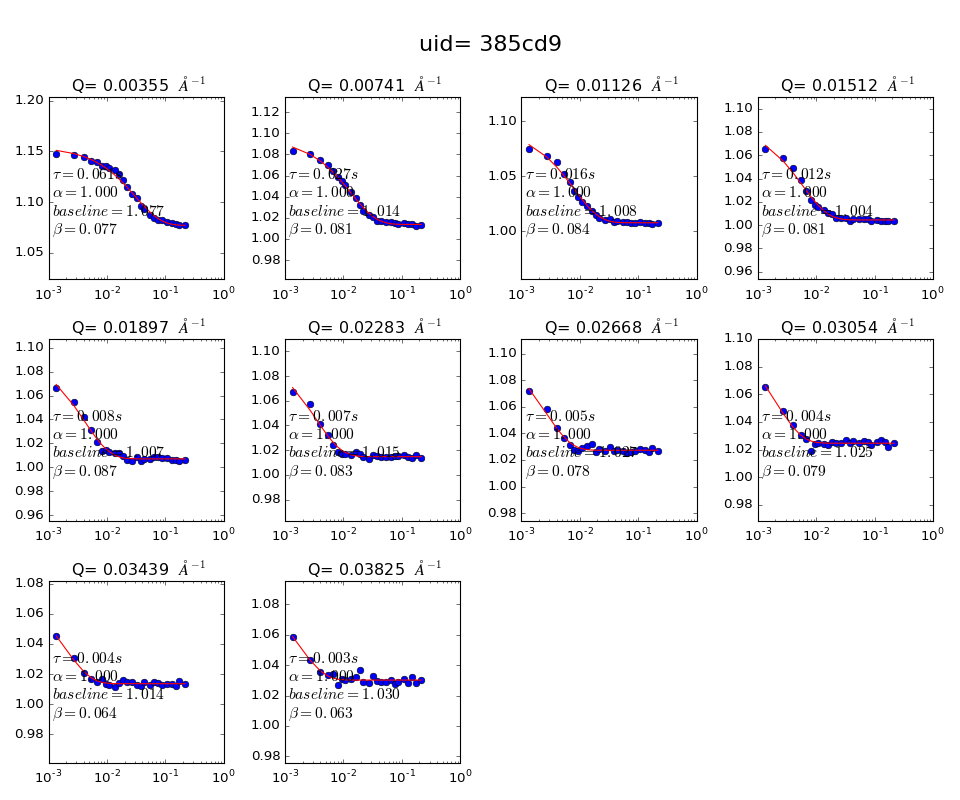

In [251]:
if fit:    
    fit_result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01})

In [252]:
psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )

In [253]:
#np.arctan2(3, 1470) *180/np.pi

In [254]:
#fig,ax=plt.subplots()
#q_nums = [10,15,20]
#for q_num in q_nums:
#    plot1D(ax=ax, x=taus[1:], y= np.array( g2 )[1:,q_num ], logx=True)

The fitted diffusion coefficient D0 is:  2.310e+05   A^2S-1


<IPython.core.display.Javascript object>


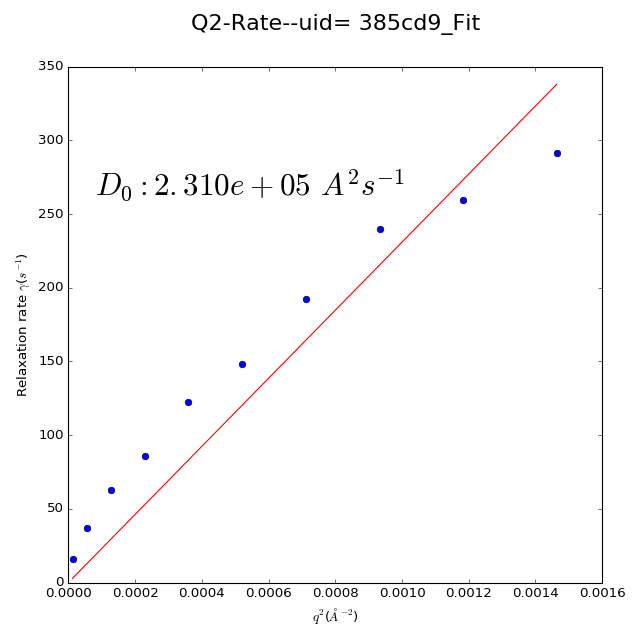

230983.41564524887

In [255]:
#fit_q_rate(  q_ring_center[6:12], result['rate'][6:12], power_variable=False,uid=uid, path= data_dir )
fit_q_rate(  q_ring_center[:], fit_result['rate'][:], power_variable= False,
           uid=uid, path= data_dir )

# For two-time

In [256]:
run_two_time = True

In [257]:
if run_two_time:
    
    if compress:
        #norm = None
        data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()
        if para_cal:
            g12b = auto_two_Arrayp(  data_pixel,  ring_mask, index = None   )
        else:    
            g12b = auto_two_Arrayc(  data_pixel,  ring_mask, index = None   )
            
        if lag_steps is None:
            num_bufs=8
            noframes = FD.end - FD.beg
            num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
            tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
            max_taus= lag_steps.max()
    else:
        qind, pixelist = roi.extract_label_indices(   ring_mask  )
        #good_start = 10
        #good_end = 300 #len( imgs )
        #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
        t0 = time.time()
        data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()

        run_time(t0)
        g12b = auto_two_Array( good_series,ring_mask, data_pixel = data_pixel ) 
        
        

100%|██████████| 10/10 [00:11<00:00,  1.68s/it]


G12 calculation DONE!


In [258]:
#if run_two_time:np.save(  data_dir + 'uid=%s-Two_time'%uid, g12b)

<IPython.core.display.Javascript object>


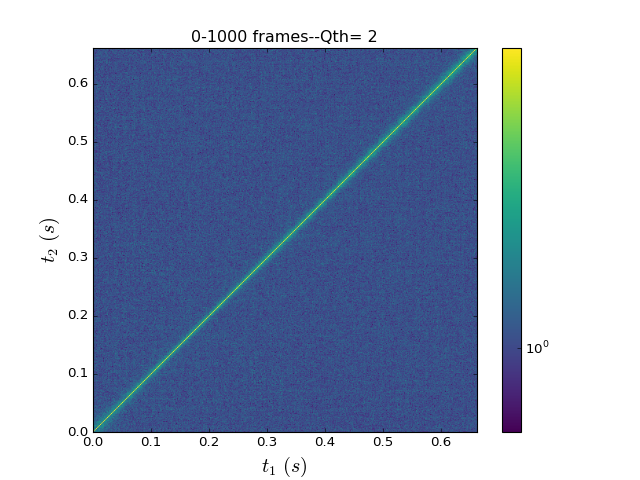

In [259]:
if run_two_time:
    show_C12(g12b, q_ind= 2, N1=0, N2=1000, vmin=.95, vmax=1.2,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid )
    

In [260]:
if run_two_time:

    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    max_taus= lag_steps.max()    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    taus2 = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g2b,  res_pargs2, taus=np.arange( g2b.shape[0]) *timeperframe,
                 filename='g2_from_two-time')

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/385cd9/ with filename as g2_from_two-time


<IPython.core.display.Javascript object>


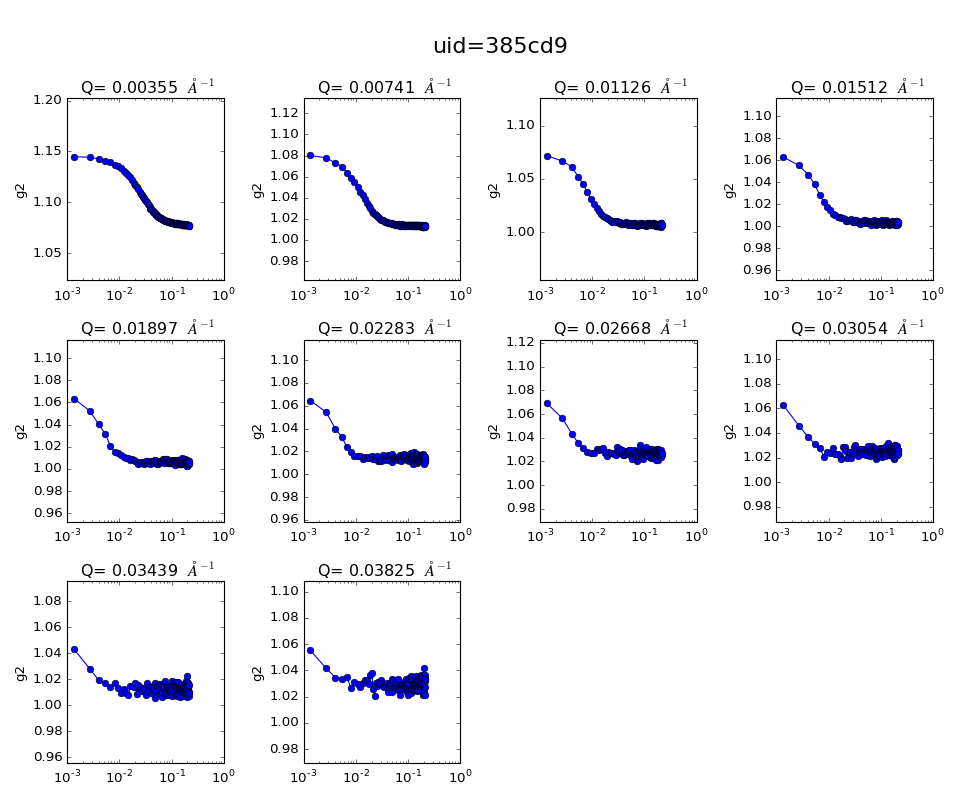

In [261]:
if run_two_time:
    plot_saxs_g2( g2b, taus2,  vlim=[0.95, 1.05], res_pargs=res_pargs2)  

<IPython.core.display.Javascript object>


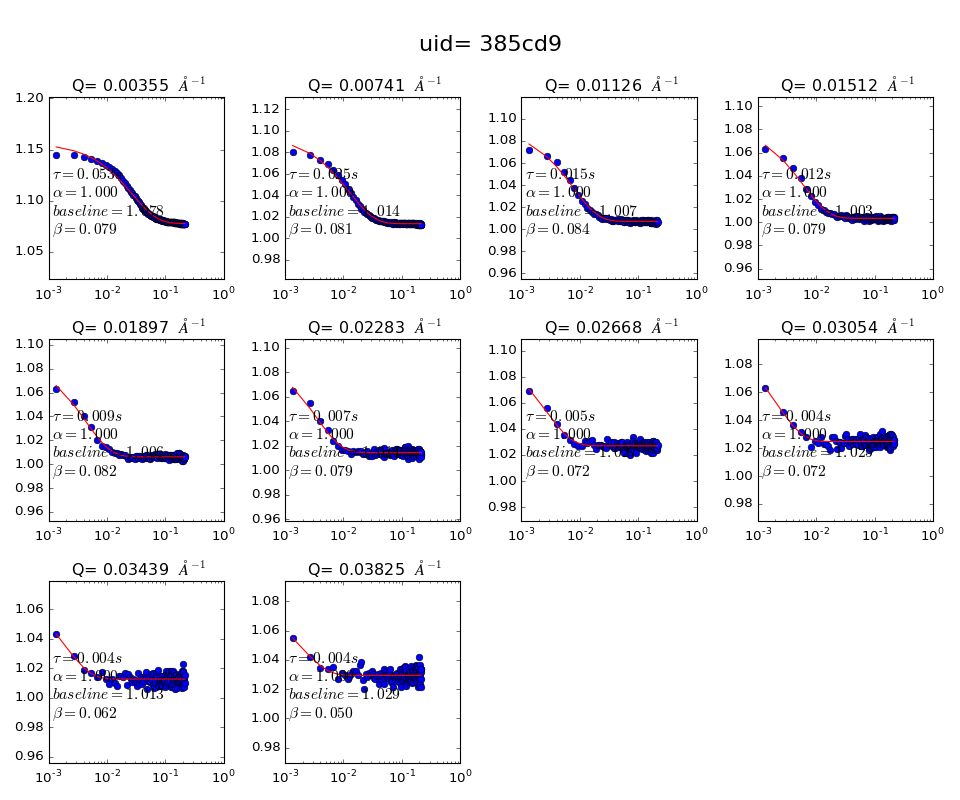

The fitted diffusion coefficient D0 is:  2.180e+05   A^2S-1


<IPython.core.display.Javascript object>


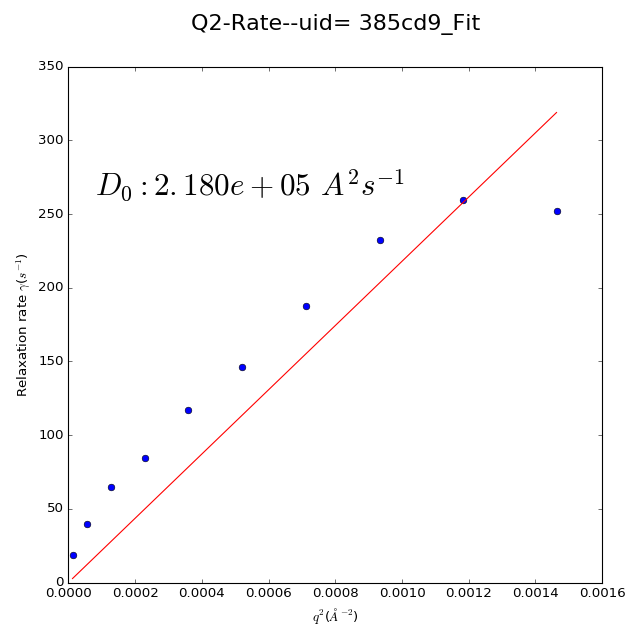

In [262]:
if run_two_time:
    result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])
    fit_q_rate(  q_ring_center, result2['rate'], uid=uid, path= data_dir )
    save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)
    
    
    

<IPython.core.display.Javascript object>


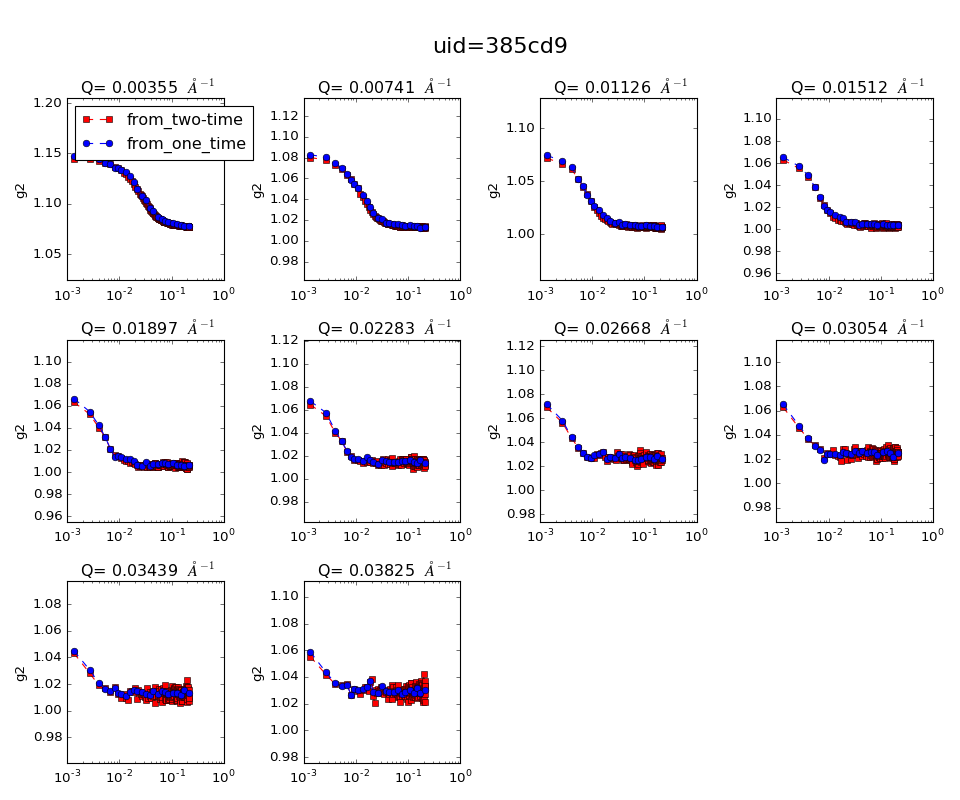

In [263]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, taus2,
                 res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid )

# Four Time Correlation

In [264]:
run_four_time = False

In [265]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

In [266]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe
    res_pargs4 = dict(taus=taus4, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g4,  res_pargs4, taus=taus4,   filename='uid=%s--g4.csv' % (uid) )


In [267]:
if run_four_time:
    plot_saxs_g4( g4, taus4,  vlim=[0.95, 1.05], logx=True, res_pargs=res_pargs4)  

# The End!

In [268]:
create_report = True


In [269]:
username

'commissioning'

In [270]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [271]:
if create_report:
    
    c= create_pdf_report(  data_dir, uid, pdf_out_dir,
                        filename= "XPCS_Analysis_Report_for_uid=%s.pdf"%uid)
    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=560, iq_fit =fit_form )
    c.report_ROI( top= 300)
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    c.report_time_analysis( top= 720)
    c.report_one_time( top= 350)
    #Page Three: two-time/two g2
    
    if run_two_time:
        c.new_page()
        c.report_header(page=3)
        c.report_two_time(  top= 720 )      
        
    if run_four_time:
        c.new_page()
        c.report_header(page=4)
        c.report_four_time(  top= 720 ) 
        
    c.save_page()
    c.done()        

    


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=385cd9.pdf
****************************************


In [272]:
c.filename

'/XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=385cd9.pdf'

In [273]:
data_dir

'/XF11ID/analysis/2016_3/commissioning/Results/385cd9/'

## Attach the PDF report to Olog 

In [274]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [275]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [276]:
c.filename

'/XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=385cd9.pdf'

In [277]:
filename = c.filename
atch=[  Attachment(open(filename, 'rb')) ] 

update_olog_uid( uid=full_uid, text='Add XPCS Analysis PDF Report', attachments= atch )

## Attach the Analysis Notebook to Olog 

In [278]:
if False:
    filename = '/XF11ID/analysis'
    for s in NOTEBOOK_FULL_PATH.split("/")[4:]:  
        filename += '/'+ s


    atch=[  Attachment(open(filename, 'rb')) ] 
    update_olog_uid( uid=uid, text='Add XPCS Analysis notebook', attachments= atch )
